# setup and imports

In [1]:
import fnmatch
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from ipywidgets import interactive
import numpy as np
import os
import glob
from scipy.ndimage import gaussian_filter as smooth
import platform

%run sessionlists
from VIGOR_utils import *
from VIGOR_plotting import *
from VIGOR_MODELS_Functions import *

plt.style.use('./Figures/paper.mplstyle')

In [2]:
#### Define folder with data 
if platform.system()=='Linux':
    root="/home/david/Desktop/ALLDATA"
    savePath="/home/david/Desktop/Save"
elif platform.system()=='Darwin':
    root="/Users/tom/Desktop/DATA"
    savePath="/Users/tom/Desktop/Save"
if 'COLAB_GPU' in os.environ:
    !gdown --id 1BSepSzm1-KQJlUvv8C23p_qyHvtzvrZ8
    !unzip -qq /content/code/sequencesALLDATA.zip
    root="/content/code/sequencesALLDATA"
    savePath="/content/Save"
    print("I'm running on Colab")
print("Path to data is: %s"%root)

retval = os.getcwd()
print("Current working directory: %s" % retval)
print("Save Path: ", savePath)

print(f'Found {len(glob.glob(root+"/*"))} rats in the data folder')

Path to data is: /home/david/Desktop/ALLDATA
Current working directory: /home/david/Desktop/code
Save Path:  /home/david/Desktop/Save
Found 26 rats in the data folder


In [3]:
rat_markers = {}
sequence = {}

# define colors for each rat
palette = {'RatF00': (0.4, 0.0, 0.0), 'RatF01': (0.55, 0.13, 0.13), 'RatF02': (0.8, 0.2, 0.2),
           'RatM00': (0.0, 0.4, 0.0), 'RatM01': (0.13, 0.55, 0.13), 'RatM02': (0.2, 0.8, 0.2),
           'RatF32': (0.8, 0.2, 0.2), 'RatF33': (0.8, 0.2, 0.2),
           'RatM31': (0.13, 0.55, 0.13), 'RatM32': (0.2, 0.8, 0.2), 
           'RatF42': (0.8, 0.2, 0.2), 'RatM40': (0.13, 0.55, 0.13), 'RatM43': (0.2, 0.8, 0.2)}

# define brain status (lesion/CNO/intact) for each rat, used in plots
# needs to be properly implemented, setting is in behav_params for each session.
brainstatus = {'RatF00': 'normal', 'RatF01': 'normal', 'RatF02': 'normal',
               'RatM00': 'normal', 'RatM01': 'normal', 'RatM02': 'normal',
               'RatF32': 'normal', 'RatF33': 'normal',
               'RatM31': 'normal', 'RatM32': 'normal',
                'RatF42': 'normal', 'RatM40': 'normal', 'RatM43': 'normal'
               }

markers = {'normal': 'o', 'thcre': 'd', 'lesion': 'x', 'biglesion': 'X'}
lines = {'normal': '-', 'thcre': '--', 'lesion': ':', 'biglesion': '-.'}

# define list of rats to be analyzed

# INTACT RATS
animalList = ['RatF00', 'RatF01', 'RatF02', 'RatM00', 'RatM01', 'RatM02', 
            'RatF32', 'RatF33', 'RatM31', 'RatM32', 'RatF42', 'RatM40', 'RatM43']


for index, animal in enumerate(animalList):
    print(f'Loading data for {animal}')
    # define marker and color for each rat, used in plots
    if fnmatch.fnmatch(animal, 'RatF*'):
        rat_markers[animal]=['silver', 'o', lines[brainstatus[animal]]]
    elif fnmatch.fnmatch(animal, 'RatM*'):
        rat_markers[animal]=['silver', 'o', lines[brainstatus[animal]]]
    elif fnmatch.fnmatch(animal, 'Rat00*'):
        rat_markers[animal]=[(0.0, 0.0, 0.0), "$\u2426$",]
    else:
        print("error, this is not a rat you got here")

    if animal == 'RatF02':
        rat_markers[animal][0] = 'orange'
        
    for session in sorted(matchsession(animal, dist60+dist90+dist120 + TM20+TM10+TM2+TMrev2+TMrev10+TMrev20)):

        biglesion = True if 'L' in session else False
        sequence[animal, session] = get_from_pickle(root, animal[0:6], session, name="sequence.p", biglesion=biglesion)

 

Loading data for RatF00
Loading data for RatF01
Loading data for RatF02
Loading data for RatM00
Loading data for RatM01
Loading data for RatM02
Loading data for RatF32
Loading data for RatF33
Loading data for RatM31
Loading data for RatM32
Loading data for RatF42
Loading data for RatM40
Loading data for RatM43


In [4]:
def plot_colorbar(ax=None, label='label', y=1.35, labelpad=-17, show_zero=None, txt=True, cmap='autumn'):
    ax.xaxis.set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    N = 4
    c = np.arange(1, 100*N + 1)
    cmap_ = plt.get_cmap(cmap, 100*N)
    dummy_ax = ax.scatter(c, c, c=c, cmap=cmap_)
    ax.cla()


    shift = 50
    if show_zero is not None:
        cb=fig.colorbar(dummy_ax, cax=ax, ticks=[np.min(c)+shift, show_zero, np.max(c)-shift])
        cb.ax.set_yticklabels(['Low', '0', 'High'], rotation=0, fontsize=5)
        ax.axhline(show_zero, color='k', lw=0.5, ls='--')

    else:
        cb=fig.colorbar(dummy_ax, cax=ax, ticks=[np.min(c)+shift, np.max(c)-shift])
        cb.ax.set_yticklabels(['Low', 'High'], rotation=0, fontsize=5)

    if not txt:
        cb.ax.set_yticklabels([])


    cb.outline.set_edgecolor(None)
    cb.set_label(label, labelpad=labelpad,y=y, rotation=0, fontsize=7)
    cb.ax.yaxis.set_tick_params(size=0)


In [5]:
def round_nearest(x, a=0.04):
    return np.around(x / a) * a

def generate_idle_time(alpha, gamma, N=1, maximum=500):
    def p(x, a, g): 
        return a / np.sqrt(2 * np.pi * x ** 3) * np.exp(-((a-g * x) ** 2) / (2 * x))
    def normalization(x, a, g): 
        return simps(p(x, a, g), x)
    x = np.linspace(1e-8, maximum, maximum*100)

    pdf = p(x, alpha, gamma)/normalization(x, alpha, gamma)
    cdf = np.cumsum(pdf); cdf /= max(cdf)
    u = np.random.uniform(0, 1, int(N))
    interp_function = interp1d(cdf, x)
    samples = interp_function(u)
    return round_nearest(samples)

# Fig Drift

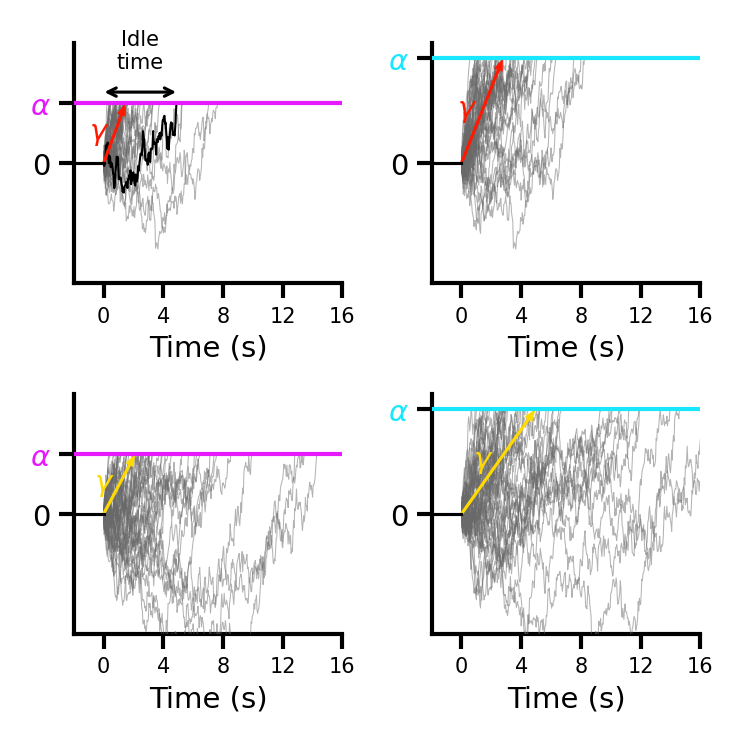

In [19]:
def Figure4_A(ax=None, mean=.2, std=1, A=10, t0=2, N=50, alphacolor='c', gammacolor='r', base=True):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(4, 4))

    np.random.seed(51)
    trials = [generate_trials(mean, std, A, 0) for _ in range(N)]

    example_plot = True
    for dv in trials:
        dv[-1] = A
        x = np.arange(len(dv))/25
        y = dv
        if base:
            if 4*25 <= len(y) < 5*25 and example_plot:
                ax.plot(x, y, c='k', lw=0.5, zorder=4)
                example_plot = False

                # idle time arrow
                ax.annotate(text='', xy=(-.5, A+1.5), xytext=(len(y)/25+.5, A+1.5), arrowprops=dict(arrowstyle='<->', lw=0.75), fontsize=5, zorder=5)
                ax.annotate(text='Idle\ntime', xy=(0, 0), xytext=(len(y)/50, A+7), ha='center', va='center',
                            xycoords='data', fontsize=5, zorder=5)
                
        ax.plot(x, y, c='dimgray', alpha=.5, zorder=3, lw=.25,)

    waits = np.array([len(t)/25 for t in trials], dtype=np.float64)

    waitmean = A / mean * np.tanh(mean * A)  #  + t0
    ax.axhline(A, c=alphacolor, zorder=5, lw=1)
    ax.set_yticks([0, A])
    ax.set_yticklabels([0, r'$\alpha$'], fontsize=7)
    ax.get_yticklabels()[1].set_color(alphacolor)
    ax.set_xlabel('Time (s)')
    ax.set_ylim(-16, 16)
    ax.set_xlim(-2, 16)
    ax.set_xticks([0, 4, 8, 12, 16])
    ax.plot((0, -t0), (0, 0), c="k", zorder=5, lw=.75)
    # space_axes(ax)


    # gamma arrow
    ax.text(waitmean/50-1, A/2, r'$\gamma$', ha="center", va="center", rotation=0, size=7, color=gammacolor, zorder=5)
    style = "Simple, head_width=.075, tail_width=0.025, head_length=.1"
    kw = dict(arrowstyle=style)
    ax.add_patch(mpatches.FancyArrowPatch((0, 0), (waitmean/25, A),
                                           shrinkA=0, shrinkB=0, 
                                            mutation_scale=30, color=gammacolor, lw=0, zorder=5, **kw))



fig, axs = plt.subplots(2, 2, figsize=(cm2inch(6), cm2inch(6)), dpi=300)
Figure4_A(ax=axs[0, 0], A=8, mean=.2, base=True, alphacolor=plt.get_cmap('cool_r')(0.1), gammacolor=plt.get_cmap('autumn')(0.1))
Figure4_A(ax=axs[0, 1], A=14, mean=.2, base=False, alphacolor=plt.get_cmap('cool_r')(0.9), gammacolor=plt.get_cmap('autumn')(0.1))
Figure4_A(ax=axs[1, 0], A=8, mean=.1, base=False, alphacolor=plt.get_cmap('cool_r')(0.1), gammacolor=plt.get_cmap('autumn')(0.85))
Figure4_A(ax=axs[1, 1], A=14, mean=.1, base=False, alphacolor=plt.get_cmap('cool_r')(0.9), gammacolor=plt.get_cmap('autumn')(0.85))


# 4A $\alpha_0 \gamma_0$

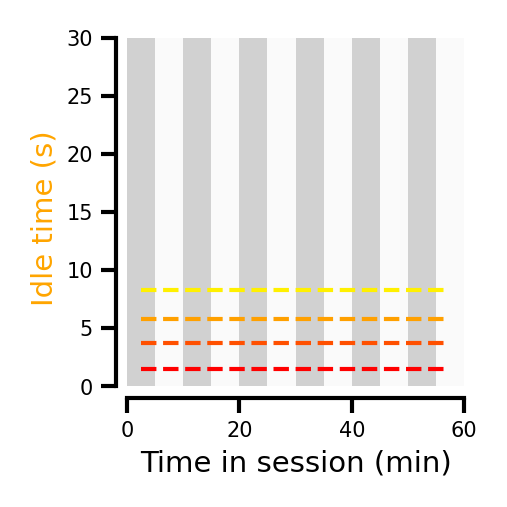

In [7]:
# plot variable median/mean fir each block
def Figure4A(ax=None, cmap=plt.get_cmap('autumn'), reverse=False):
    if ax is None:
        ax = plt.gca()

    rewardProbaBlock = [90, 10, 90, 10, 90, 10, 90, 10, 90, 10, 90, 10]
    blocks =  [[0, 300],  [300, 600],  [600, 900],  [900, 1200],
                [1200, 1500],  [1500, 1800],  [1800, 2100],  [2100, 2400],
                [2400, 2700],  [2700, 3000],  [3000, 3300],  [3300, 3600]]

    dummy_data = [2.75, 2.75, 2.75, 2.75, 2.75, 2.75, 2.75, 2.75, 2.75, 2.75, 2.75, 2.75]
    modifs = [-1.25, 1, 3, 5.5]
    if reverse:
        modifs = modifs[::-1]
    cmap = cmap
    for idx, modif in enumerate(modifs):
        ax.plot([(blocks[i][1] + blocks[i][0])/120 for i in range(0, len(blocks))], 
                [dummy_data[i] + modif for i in range(0, len(blocks))],
                color=cmap((1.25*idx)/len(modifs)), ls='--')

    for i in range(0, len(blocks)):
        ax.axvspan(blocks[i][0]/60, blocks[i][1]/60, ymin=1/30, ymax=1, color='grey', alpha=rewardProbaBlock[i]/250, lw=0)
    
    ax.set_xlabel("Time in session (min)")
    ax.set_ylabel("Idle time (s)", color='orange')
    ax.set_xlim(0, 60)
    ax.set_xticks([0, 20, 40, 60])
    ax.set_ylim(0, 30)
    space_axes(ax)

fig, ax = plt.subplots(1, 1, figsize=(cm2inch(4), cm2inch(4)))
Figure4A(ax=ax)

# 4B  $\alpha_t \gamma_t$

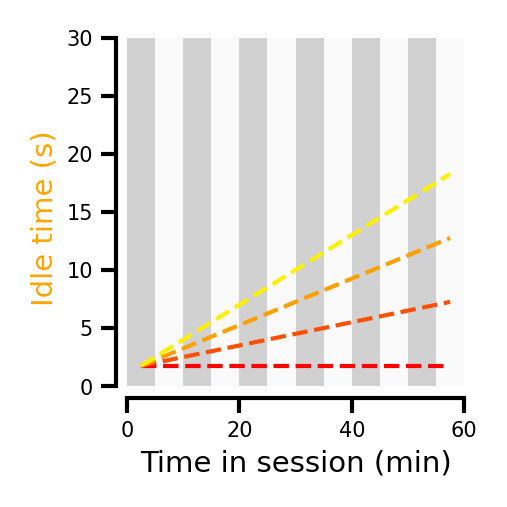

In [8]:
# plot variable median/mean fir each block
def Figure4B(ax=None, cmap=plt.get_cmap('autumn'), reverse=False):

    if ax is None:
        ax = plt.gca()

    rewardProbaBlock = [90, 10, 90, 10, 90, 10, 90, 10, 90, 10, 90, 10]
    blocks =  [[0, 300],  [300, 600],  [600, 900],  [900, 1200],
                [1200, 1500],  [1500, 1800],  [1800, 2100],  [2100, 2400],
                [2400, 2700],  [2700, 3000],  [3000, 3300],  [3300, 3600]]

    dummy_data = [1.75, 1.75, 1.75, 1.75, 1.75, 1.75, 1.75, 1.75, 1.75, 1.75, 1.75, 1.75]
    modifs = [0, 0.5, 1, 1.5]
    if reverse:
        modifs = modifs[::-1]
    cmap = cmap
    
    for idx, modif in enumerate(modifs):
        ax.plot([(blocks[i][1] + blocks[i][0])/120 for i in range(0, len(blocks))], 
                [dummy_data[i] + (i*modif) for i in range(0, len(blocks))],
                color=cmap((1.25*idx)/len(modifs)), ls='--')

    for i in range(0, len(blocks)):
        ax.axvspan(blocks[i][0]/60, blocks[i][1]/60, ymin=1/30, ymax=1, color='grey', alpha=rewardProbaBlock[i]/250, lw=0)
    
    ax.set_xlabel("Time in session (min)")
    ax.set_ylabel("Idle time (s)", color='orange')
    ax.set_xticks([0, 20, 40, 60])
    ax.set_xlim(0, 60)
    ax.set_ylim(0, 30)
    space_axes(ax)

fig, ax = plt.subplots(1, 1, figsize=(cm2inch(4), cm2inch(4)))
Figure4B(ax=ax)

# 4C  $\alpha_R \gamma_R$

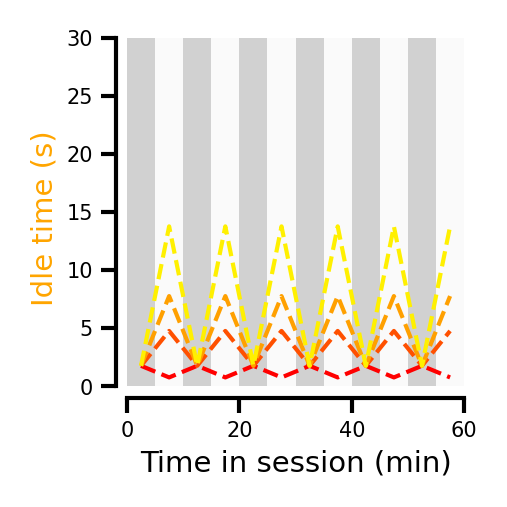

In [9]:
# plot variable median/mean fir each block
def Figure4C(ax=None, cmap=plt.get_cmap('autumn'), reverse=False):

    if ax is None:
        ax = plt.gca()

    rewardProbaBlock = [90, 10, 90, 10, 90, 10, 90, 10, 90, 10, 90, 10]
    blocks =  [[0, 300],  [300, 600],  [600, 900],  [900, 1200],
                [1200, 1500],  [1500, 1800],  [1800, 2100],  [2100, 2400],
                [2400, 2700],  [2700, 3000],  [3000, 3300],  [3300, 3600]]

    dummy_data = [1.75, 1.75, 1.75, 1.75, 1.75, 1.75, 1.75, 1.75, 1.75, 1.75, 1.75, 1.75]
    modifs = [-1, 3, 6, 12]
    if reverse:
        modifs = modifs[::-1]
    cmap = cmap
    for idx, modif in enumerate(modifs):
        ax.plot([(blocks[i][1] + blocks[i][0])/120 for i in range(0, len(blocks))], 
                [dummy_data[i] + modif if i % 2 == 1 else dummy_data[i] for i in range(0, len(blocks)) ],
                color=cmap((1.25*idx)/len(modifs)), ls='--')

    for i in range(0, len(blocks)):
        ax.axvspan(blocks[i][0]/60, blocks[i][1]/60, ymin=1/30, ymax=1, color='grey', alpha=rewardProbaBlock[i]/250, lw=0)

    ax.set_xlabel("Time in session (min)")
    ax.set_ylabel("Idle time (s)", color='orange')
    ax.set_xticks([0, 20, 40, 60])
    ax.set_xlim(0, 60)
    ax.set_ylim(0, 30)
    space_axes(ax)

fig, ax = plt.subplots(1, 1, figsize=(cm2inch(4), cm2inch(4)))
Figure4C(ax=ax)

# 4D model + data

[0.812139792180911, 1.6139910699615434, 1.1692466361479221, 1.9710979139285543, 1.5263534801149332, 2.328204757895566, 1.8834603240819443, 2.6853116018625762, 2.240567168048955, 3.0424184458295875, 2.597674012015966, 3.399525289796598]
[0.47336514094924226, 0.23649916083298797, 0.4262800826115629, 0.1894141024953086, 0.3791950242738835, 0.14232904415762918, 0.3321099659362041, 0.09524398581994983, 0.2850249075985248, 0.048158927482270464, 0.23793984926084544, 0.001073869144591108]


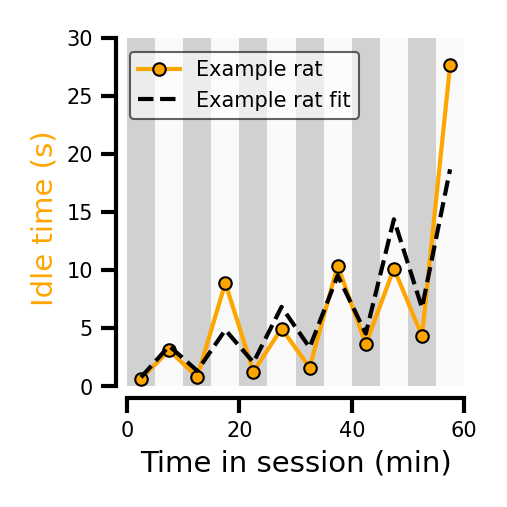

In [10]:
# plot variable median/mean fir each block
def Figure4D(ax=None):
    if ax is None:
        ax = plt.gca()

    rewardProbaBlock = [90, 10, 90, 10, 90, 10, 90, 10, 90, 10, 90, 10]
    blocks =  [[0, 300],  [300, 600],  [600, 900],  [900, 1200],
                [1200, 1500],  [1500, 1800],  [1800, 2100],  [2100, 2400],
                [2400, 2700],  [2700, 3000],  [3000, 3300],  [3300, 3600]]

    dummy_data = [1.25, 2.25, 1.5, 2.75, 2, 3.5, 2.4, 4.2, 3.2, 5.2, 3.5, 6.3]
    # ax.plot([(blocks[i][1] + blocks[i][0])/120 for i in range(0, len(blocks))], 
    #         [dummy_data[i] for i in range(0, len(blocks))],  # or use median
    #         color='orange', 
    #         zorder=4, markeredgecolor='k', markeredgewidth=0.5,
    #         ls='--', label='Synthetic data')
    
    for i in range(0, len(blocks)):
        ax.axvspan(blocks[i][0]/60, blocks[i][1]/60, ymin=1/30, ymax=1, color='grey', alpha=rewardProbaBlock[i]/250, lw=0)
    
    ax.set_xlabel("Time in session (min)")
    ax.set_ylabel("Idle time (s)", color='orange')
    ax.set_xlim(0, 60)
    ax.set_ylim(0, 30)
    # ax.set_yticks([0, 5, 10, 15])
    space_axes(ax)


    # experimental rat data

    root = "/home/david/Desktop/ALLDATA"
    animal = 'RatF02'
    session = 'RatF02_2021_07_22_18_14_16' 

    _params = get_from_pickle(root, animal, session, name="params.p")
    blocks = _params['blocks']
    rewardProbaBlock = _params['rewardProbaBlock']
    example_runningTimeInLeftBin, example_runningTimeInRightBin = get_from_pickle(root, animal, session, name="timeinZone.p")
    data = [example_runningTimeInLeftBin[i]+example_runningTimeInRightBin[i] for i in range(0, 12)]

    ax.plot([(blocks[i][1] + blocks[i][0])/120 for i in range(0, len(blocks))], 
            [np.median(data[i]) for i in range(0, len(blocks))],
            marker='o', ms=3, color='orange', 
            zorder=4, markeredgecolor='k', markeredgewidth=0.5, alpha=1, label='Example rat')



    # fit, generate samples from distribution with fit parameters, take median
    N_bins = 6
    N_avg = 4
    ex_alpha, ex_alpha_t, ex_alpha_R, ex_gamma, ex_gamma_t, ex_gamma_R = pickle.load(open("picklejar/idle_time_fit_example_session.p", "rb"))
    ALPHA = np.zeros((N_bins, N_avg))
    GAMMA = np.zeros((N_bins, N_avg))

    for bin in range(N_bins):
        for avg in range(N_avg):
            ALPHA[bin, avg] = ex_alpha + bin*ex_alpha_t + avg*ex_alpha_R
            GAMMA[bin, avg] = ex_gamma + bin*ex_gamma_t + avg*ex_gamma_R

    a = []
    g = []
    for i in range(6):
        a.append(ALPHA[i][0]+0.1*ALPHA[i][1])
        a.append(ALPHA[i][-1]+0.1*ALPHA[i][-2])
        g.append(GAMMA[i][0]+0.1*GAMMA[i][1])
        g.append(GAMMA[i][-1]+0.1*GAMMA[i][-2])

    print(a)
    print(g)


    res = [np.median(generate_idle_time(a[i], g[i], 1000)) for i in range(12)]

    ax.plot([(blocks[i][1] + blocks[i][0])/120 for i in range(0, len(blocks))],
            [res[i] for i in range(0, len(blocks))],  # or use median
            color='k', ls='--', label='Example rat fit', zorder=5)


    handles, labels = ax.get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    ax.legend(*zip(*unique), loc='upper left', bbox_to_anchor=(0.01, 0.99), frameon=True, fontsize=5, markerscale=1, edgecolor='k', facecolor='w').get_frame().set_linewidth(.5)


fig, ax = plt.subplots(1, 1, figsize=(cm2inch(4), cm2inch(4)))
Figure4D(ax=ax)

# 4FGH fit result dist

In [11]:
alpha_0, alpha_t, alpha_R, gamma_0, gamma_t, gamma_R, mu_0, mu_t, mu_R, sigma_0, sigma_t, sigma_R = pickle.load(open("picklejar/intact_lesionFITS.p", "rb"))
ylabelsIDLE = [r'$\alpha_0$', r"$\alpha_t$", r"$\alpha_R$", r'$\gamma_0$', r"$\gamma_t$", r"$\gamma_R$"]
ylimsIDLE = [[-.5, 3], [-.1, .65], [-.45, .5], [-.2, 1.6], [-.25, .1], [-.35, .1]]


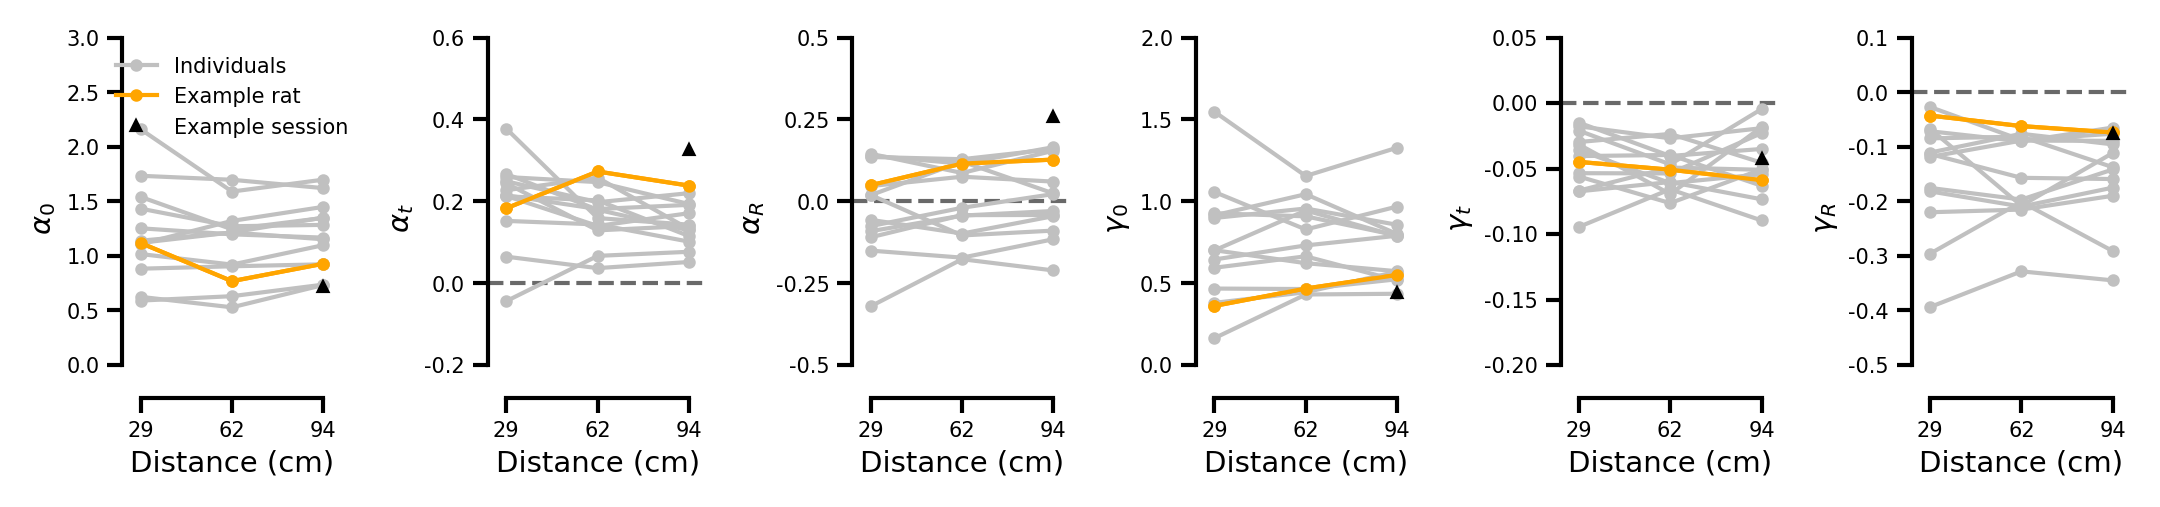

In [12]:
def Figure4F(ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))

    # ax.axhline(0, color='black', linestyle='--', linewidth=1, alpha=0.5, zorder=0)

    alpha_0, alpha_t, alpha_R, gamma_0, gamma_t, gamma_R, mu_0, mu_t, mu_R, sigma_0, sigma_t, sigma_R = pickle.load(open("picklejar/intact_lesionFITS.p", "rb"))

    for animal in animalList:
        ax.plot([0, 1, 2], [alpha_0[animal]["60"], alpha_0[animal]["90"], alpha_0[animal]["120"]], 
                        color=rat_markers[animal][0], marker=rat_markers[animal][1], 
                        markersize=2, linestyle=lines[brainstatus[animal]], label='Individuals')
        
        if animal == 'RatF02':
            ax.plot([0, 1, 2], [alpha_0[animal]["60"], alpha_0[animal]["90"], alpha_0[animal]["120"]], 
                        color=rat_markers[animal][0], marker=rat_markers[animal][1], 
                        markersize=2, linestyle=lines[brainstatus[animal]], zorder=5, label='Example rat')

    
    ex_alpha, ex_alpha_t, ex_alpha_R, ex_gamma, ex_gamma_t, ex_gamma_R = pickle.load(open("picklejar/idle_time_fit_example_session.p", "rb"))
    ax.plot(2, ex_alpha, color='black', marker='^', zorder=10, markersize=2, linewidth=0, label='Example session')
    
    
    ax.set_xlim(0, 2)
    ax.set_xticks([0, 1, 2])
    ax.set_xticklabels(["29", "62", "94"])
    ax.set_xlabel("Distance (cm)")

    ax.set_ylim(0, 3)
    ax.set_ylabel(r'$\alpha_0$')
    space_axes(ax, y_ratio=.1, x_ratio_left=.1, x_ratio_right=.1)

    handles, labels = ax.get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    ax.legend(*zip(*unique), loc='upper center',# bbox_to_anchor=(0.01, 0.99), 
                                frameon=False, fontsize=5, markerscale=1, 
                                edgecolor='k', facecolor='w').get_frame().set_linewidth(.5)


def Figure4G(ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))

    alpha_0, alpha_t, alpha_R, gamma_0, gamma_t, gamma_R, mu_0, mu_t, mu_R, sigma_0, sigma_t, sigma_R = pickle.load(open("picklejar/intact_lesionFITS.p", "rb"))

    for animal in animalList:
        ax.plot([0, 1, 2], [alpha_t[animal]["60"], alpha_t[animal]["90"], alpha_t[animal]["120"]], 
                        color=rat_markers[animal][0], label=animal, marker=rat_markers[animal][1], 
                        markersize=2, linestyle=lines[brainstatus[animal]])

        if animal == 'RatF02':
            ax.plot([0, 1, 2], [alpha_t[animal]["60"], alpha_t[animal]["90"], alpha_t[animal]["120"]], 
                            color=rat_markers[animal][0], label=animal, marker=rat_markers[animal][1], 
                            markersize=2, linestyle=lines[brainstatus[animal]], zorder=10)
    

    ex_alpha, ex_alpha_t, ex_alpha_R, ex_gamma, ex_gamma_t, ex_gamma_R = pickle.load(open("picklejar/idle_time_fit_example_session.p", "rb"))
    ax.plot(2, ex_alpha_t, color='black', marker='^', zorder=10, markersize=2, linewidth=0)
    


    ax.set_xlim(0, 2)
    ax.set_xticks([0, 1, 2])
    ax.set_xticklabels(["29", "62", "94"])
    ax.set_xlabel("Distance (cm)")

    ax.set_ylim(-.2, .6)
    ax.set_ylabel(r'$\alpha_t$')

    ax.axhline(0, color='dimgray', linestyle='--', linewidth=1, alpha=1, zorder=0)
    space_axes(ax, y_ratio=.1, x_ratio_left=.1, x_ratio_right=.1)


def Figure4H(ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))

    alpha_0, alpha_t, alpha_R, gamma_0, gamma_t, gamma_R, mu_0, mu_t, mu_R, sigma_0, sigma_t, sigma_R = pickle.load(open("picklejar/intact_lesionFITS.p", "rb"))

    for animal in animalList:
        ax.plot([0, 1, 2], [alpha_R[animal]["60"], alpha_R[animal]["90"], alpha_R[animal]["120"]], 
                        color=rat_markers[animal][0], label=animal, marker=rat_markers[animal][1], 
                        markersize=2, linestyle=lines[brainstatus[animal]])
        
        if animal == 'RatF02':
            ax.plot([0, 1, 2], [alpha_R[animal]["60"], alpha_R[animal]["90"], alpha_R[animal]["120"]], 
                        color=rat_markers[animal][0], label=animal, marker=rat_markers[animal][1], 
                        markersize=2, linestyle=lines[brainstatus[animal]], zorder=10)


    ex_alpha, ex_alpha_t, ex_alpha_R, ex_gamma, ex_gamma_t, ex_gamma_R = pickle.load(open("picklejar/idle_time_fit_example_session.p", "rb"))
    ax.plot(2, ex_alpha_R, color='black', marker='^', zorder=10, markersize=2, linewidth=0)
    
    ax.set_xlim(0, 2)
    ax.set_xticks([0, 1, 2])
    ax.set_xticklabels(["29", "62", "94"])
    ax.set_xlabel("Distance (cm)")

    ax.set_ylim(-0.5, .5)
    ax.set_yticks([-0.5, -.25, 0, .25, 0.5])
    ax.set_yticklabels(["-0.5", -.25, "0.0", .25, "0.5"])
    ax.set_ylabel(r'$\alpha_R$')

    ax.axhline(0, color='dimgray', linestyle='--', linewidth=1, alpha=1, zorder=0)
    space_axes(ax, y_ratio=.1, x_ratio_left=.1, x_ratio_right=.1)



def Figure4I(ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))

    # ax.axhline(0, color='black', linestyle='--', linewidth=1, alpha=0.5, zorder=0)

    alpha_0, alpha_t, alpha_R, gamma_0, gamma_t, gamma_R, mu_0, mu_t, mu_R, sigma_0, sigma_t, sigma_R = pickle.load(open("picklejar/intact_lesionFITS.p", "rb"))

    for animal in animalList:
        ax.plot([0, 1, 2], [gamma_0[animal]["60"], gamma_0[animal]["90"], gamma_0[animal]["120"]], 
                        color=rat_markers[animal][0], marker=rat_markers[animal][1], 
                        markersize=2, linestyle=lines[brainstatus[animal]], label='Individuals')
        
        if animal == 'RatF02':
            ax.plot([0, 1, 2], [gamma_0[animal]["60"], gamma_0[animal]["90"], gamma_0[animal]["120"]], 
                        color=rat_markers[animal][0], marker=rat_markers[animal][1], 
                        markersize=2, linestyle=lines[brainstatus[animal]], zorder=5, label='Example rat')

    
    ex_alpha, ex_alpha_t, ex_alpha_R, ex_gamma, ex_gamma_t, ex_gamma_R = pickle.load(open("picklejar/idle_time_fit_example_session.p", "rb"))
    ax.plot(2, ex_gamma, color='black', marker='^', zorder=10, markersize=2, linewidth=0, label='Example session')
    
    
    ax.set_xlim(0, 2)
    ax.set_xticks([0, 1, 2])
    ax.set_xticklabels(["29", "62", "94"])
    ax.set_xlabel("Distance (cm)")

    ax.set_ylim(0, 2)
    ax.set_ylabel(r'$\gamma_0$')
    space_axes(ax, y_ratio=.1, x_ratio_left=.1, x_ratio_right=.1)

def Figure4J(ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))

    alpha_0, alpha_t, alpha_R, gamma_0, gamma_t, gamma_R, mu_0, mu_t, mu_R, sigma_0, sigma_t, sigma_R = pickle.load(open("picklejar/intact_lesionFITS.p", "rb"))

    for animal in animalList:
        ax.plot([0, 1, 2], [gamma_t[animal]["60"], gamma_t[animal]["90"], gamma_t[animal]["120"]], 
                        color=rat_markers[animal][0], label=animal, marker=rat_markers[animal][1], 
                        markersize=2, linestyle=lines[brainstatus[animal]])

        if animal == 'RatF02':
            ax.plot([0, 1, 2], [gamma_t[animal]["60"], gamma_t[animal]["90"], gamma_t[animal]["120"]], 
                            color=rat_markers[animal][0], label=animal, marker=rat_markers[animal][1], 
                            markersize=2, linestyle=lines[brainstatus[animal]], zorder=10)
    

    ex_alpha, ex_alpha_t, ex_alpha_R, ex_gamma, ex_gamma_t, ex_gamma_R = pickle.load(open("picklejar/idle_time_fit_example_session.p", "rb"))
    ax.plot(2, ex_gamma_t, color='black', marker='^', zorder=10, markersize=2, linewidth=0)
    

    ax.set_xlim(0, 2)
    ax.set_xticks([0, 1, 2])
    ax.set_xticklabels(["29", "62", "94"])
    ax.set_xlabel("Distance (cm)")

    ax.set_ylim(-0.2, .05)
    ax.set_ylabel(r'$\gamma_t$')

    ax.axhline(0, color='dimgray', linestyle='--', linewidth=1, alpha=1, zorder=0)
    space_axes(ax, y_ratio=.1, x_ratio_left=.1, x_ratio_right=.1)


def Figure4K(ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))

    alpha_0, alpha_t, alpha_R, gamma_0, gamma_t, gamma_R, mu_0, mu_t, mu_R, sigma_0, sigma_t, sigma_R = pickle.load(open("picklejar/intact_lesionFITS.p", "rb"))

    for animal in animalList:
        ax.plot([0, 1, 2], [gamma_R[animal]["60"], gamma_R[animal]["90"], gamma_R[animal]["120"]], 
                        color=rat_markers[animal][0], label=animal, marker=rat_markers[animal][1], 
                        markersize=2, linestyle=lines[brainstatus[animal]])
        
        if animal == 'RatF02':
            ax.plot([0, 1, 2], [gamma_R[animal]["60"], gamma_R[animal]["90"], gamma_R[animal]["120"]], 
                        color=rat_markers[animal][0], label=animal, marker=rat_markers[animal][1], 
                        markersize=2, linestyle=lines[brainstatus[animal]], zorder=10)


    ex_alpha, ex_alpha_t, ex_alpha_R, ex_gamma, ex_gamma_t, ex_gamma_R = pickle.load(open("picklejar/idle_time_fit_example_session.p", "rb"))
    ax.plot(2, ex_gamma_R, color='black', marker='^', zorder=10, markersize=2, linewidth=0)
    
    ax.set_xlim(0, 2)
    ax.set_xticks([0, 1, 2])
    ax.set_xticklabels(["29", "62", "94"])
    ax.set_xlabel("Distance (cm)")

    ax.set_ylim(-0.5, 0.1)
    ax.set_ylabel(r'$\gamma_R$')
    
    ax.axhline(0, color='dimgray', linestyle='--', linewidth=1, alpha=1, zorder=0)
    space_axes(ax, y_ratio=.1, x_ratio_left=.1, x_ratio_right=.1)



fig, axs = plt.subplots(1, 6, figsize=(cm2inch(18), cm2inch(4)))
Figure4F(axs[0])
Figure4G(axs[1])
Figure4H(axs[2])
Figure4I(axs[3])
Figure4J(axs[4])
Figure4K(axs[5])


# # This is a hack to get the legend to not mess up the spacing
# handles, labels = axs[0].get_legend_handles_labels()
# unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
# fig.legend(*zip(*unique), loc='upper center',# bbox_to_anchor=(0.01, 0.99), 
#                             frameon=False, fontsize=5, markerscale=1, 
#                             edgecolor='k', facecolor='w').get_frame().set_linewidth(.5)

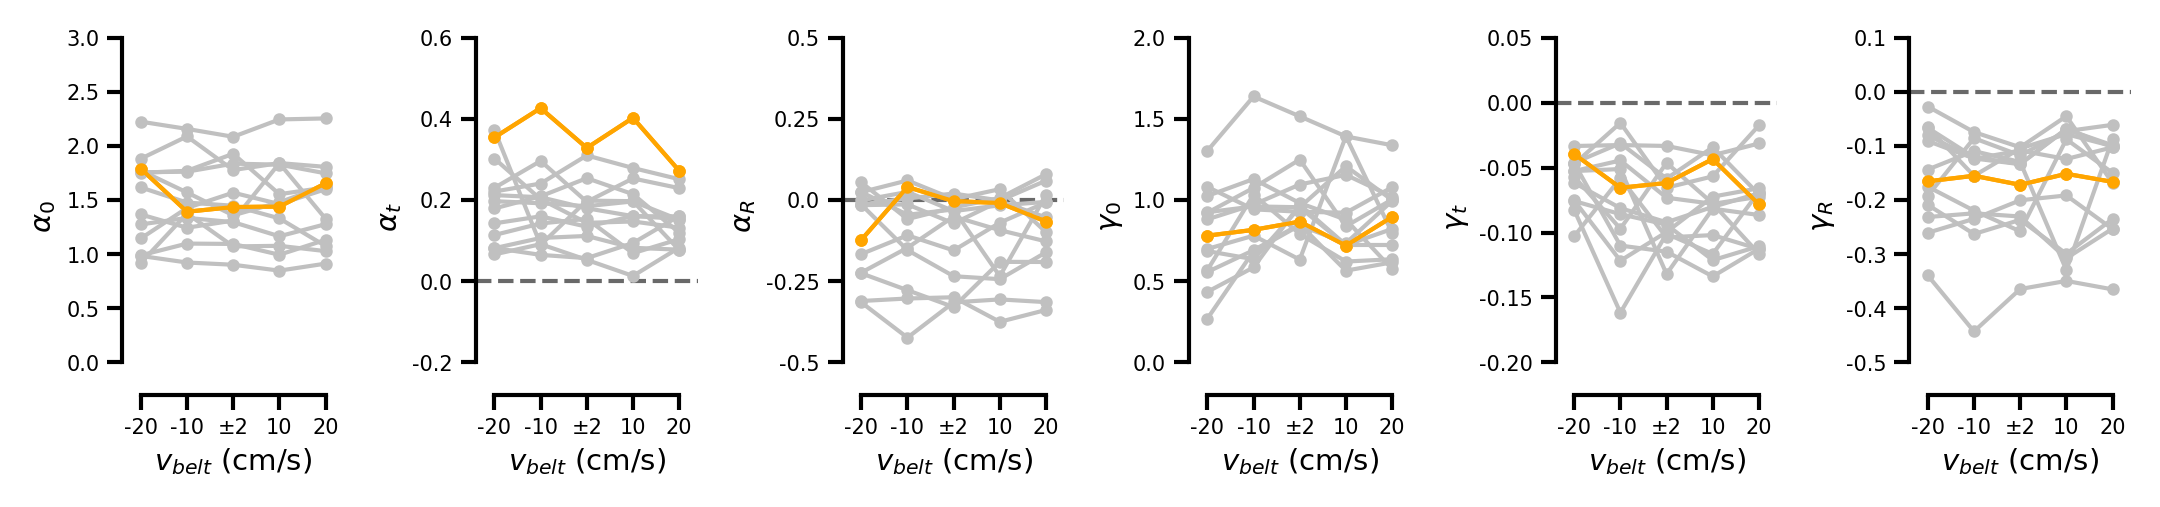

In [13]:
def Figure4L(ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))

    # ax.axhline(0, color='black', linestyle='--', linewidth=1, alpha=0.5, zorder=0)

    alpha_0, alpha_t, alpha_R, gamma_0, gamma_t, gamma_R, mu_0, mu_t, mu_R, sigma_0, sigma_t, sigma_R = pickle.load(open("picklejar/intact_lesionFITS.p", "rb"))

    for animal in animalList:
        ax.plot([0, 1, 2, 3, 4], [alpha_0[animal]["rev20"], alpha_0[animal]["rev10"], alpha_0[animal]["2"], alpha_0[animal]["10"], alpha_0[animal]["20"]], 
                        color=rat_markers[animal][0], marker=rat_markers[animal][1], 
                        markersize=2, linestyle=lines[brainstatus[animal]], label='Individuals')
        
        if animal == 'RatF02':
            ax.plot([0, 1, 2, 3, 4], [alpha_0[animal]["rev20"], alpha_0[animal]["rev10"], alpha_0[animal]["2"], alpha_0[animal]["10"], alpha_0[animal]["20"]], 
                        color=rat_markers[animal][0], marker=rat_markers[animal][1], 
                        markersize=2, linestyle=lines[brainstatus[animal]], zorder=5, label='Example rat')

    ax.set_xlim(0, 4)
    ax.set_xticks([0, 1, 2, 3, 4])
    ax.set_xticklabels(["-20", "-10", "±2", "10", "20"])
    _ = r'$v_{belt}$'
    ax.set_xlabel(f'{_} (cm/s)')

    ax.set_ylim(0, 3)
    ax.set_ylabel(r'$\alpha_0$')

    space_axes(ax, y_ratio=.1, x_ratio_left=.1, x_ratio_right=.1)


def Figure4M(ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))

    alpha_0, alpha_t, alpha_R, gamma_0, gamma_t, gamma_R, mu_0, mu_t, mu_R, sigma_0, sigma_t, sigma_R = pickle.load(open("picklejar/intact_lesionFITS.p", "rb"))

    for animal in animalList:
        ax.plot([0, 1, 2, 3, 4], [alpha_t[animal]["rev20"], alpha_t[animal]["rev10"], alpha_t[animal]["2"], alpha_t[animal]["10"], alpha_t[animal]["20"]], 
                        color=rat_markers[animal][0], label=animal, marker=rat_markers[animal][1], 
                        markersize=2, linestyle=lines[brainstatus[animal]])

        if animal == 'RatF02':
            ax.plot([0, 1, 2, 3, 4], [alpha_t[animal]["rev20"], alpha_t[animal]["rev10"], alpha_t[animal]["2"], alpha_t[animal]["10"], alpha_t[animal]["20"]], 
                            color=rat_markers[animal][0], label=animal, marker=rat_markers[animal][1], 
                            markersize=2, linestyle=lines[brainstatus[animal]], zorder=10)

    ax.set_xlim(0, 4)
    ax.set_xticks([0, 1, 2, 3, 4])
    ax.set_xticklabels(["-20", "-10", "±2", "10", "20"])
    _ = r'$v_{belt}$'
    ax.set_xlabel(f'{_} (cm/s)')

    ax.set_ylim(-0.2, .6)
    ax.set_ylabel(r'$\alpha_t$')
    ax.axhline(0, color='dimgray', linestyle='--', linewidth=1, alpha=1, zorder=0)

    space_axes(ax, y_ratio=.1, x_ratio_left=.1, x_ratio_right=.1)


def Figure4N(ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))

    alpha_0, alpha_t, alpha_R, gamma_0, gamma_t, gamma_R, mu_0, mu_t, mu_R, sigma_0, sigma_t, sigma_R = pickle.load(open("picklejar/intact_lesionFITS.p", "rb"))

    for animal in animalList:
        ax.plot([0, 1, 2, 3, 4], [alpha_R[animal]["rev20"], alpha_R[animal]["rev10"], alpha_R[animal]["2"], alpha_R[animal]["10"], alpha_R[animal]["20"]], 
                        color=rat_markers[animal][0], label=animal, marker=rat_markers[animal][1], 
                        markersize=2, linestyle=lines[brainstatus[animal]])
        
        if animal == 'RatF02':
            ax.plot([0, 1, 2, 3, 4], [alpha_R[animal]["rev20"], alpha_R[animal]["rev10"], alpha_R[animal]["2"], alpha_R[animal]["10"], alpha_R[animal]["20"]], 
                        color=rat_markers[animal][0], label=animal, marker=rat_markers[animal][1], 
                        markersize=2, linestyle=lines[brainstatus[animal]], zorder=10)

    ax.set_xlim(0, 4)
    ax.set_xticks([0, 1, 2, 3, 4])
    ax.set_xticklabels(["-20", "-10", "±2", "10", "20"])
    _ = r'$v_{belt}$'
    ax.set_xlabel(f'{_} (cm/s)')

    ax.set_ylim(-0.5, 0.5)
    ax.set_yticks([-0.5, -.25, 0, .25, 0.5])
    ax.set_yticklabels(["-0.5", -.25, "0.0", .25, "0.5"])
    ax.set_ylabel(r'$\alpha_R$')

    ax.axhline(0, color='dimgray', linestyle='--', linewidth=1, alpha=1, zorder=0)
    space_axes(ax, y_ratio=.1, x_ratio_left=.1, x_ratio_right=.1)




def Figure4O(ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))

    # ax.axhline(0, color='black', linestyle='--', linewidth=1, alpha=0.5, zorder=0)

    alpha_0, alpha_t, alpha_R, gamma_0, gamma_t, gamma_R, mu_0, mu_t, mu_R, sigma_0, sigma_t, sigma_R = pickle.load(open("picklejar/intact_lesionFITS.p", "rb"))

    for animal in animalList:
        ax.plot([0, 1, 2, 3, 4], [gamma_0[animal]["rev20"], gamma_0[animal]["rev10"], gamma_0[animal]["2"], gamma_0[animal]["10"], gamma_0[animal]["20"]], 
                        color=rat_markers[animal][0], marker=rat_markers[animal][1], 
                        markersize=2, linestyle=lines[brainstatus[animal]], label='Individuals')
        
        if animal == 'RatF02':
            ax.plot([0, 1, 2, 3, 4], [gamma_0[animal]["rev20"], gamma_0[animal]["rev10"], gamma_0[animal]["2"], gamma_0[animal]["10"], gamma_0[animal]["20"]], 
                        color=rat_markers[animal][0], marker=rat_markers[animal][1], 
                        markersize=2, linestyle=lines[brainstatus[animal]], zorder=5, label='Example rat')

    ax.set_xlim(0, 4)
    ax.set_xticks([0, 1, 2, 3, 4])
    ax.set_xticklabels(["-20", "-10", "±2", "10", "20"])
    _ = r'$v_{belt}$'
    ax.set_xlabel(f'{_} (cm/s)')

    ax.set_ylim(0, 2)
    ax.set_ylabel(r'$\gamma_0$')
    space_axes(ax, y_ratio=.1, x_ratio_left=.1, x_ratio_right=.1)

def Figure4P(ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))

    alpha_0, alpha_t, alpha_R, gamma_0, gamma_t, gamma_R, mu_0, mu_t, mu_R, sigma_0, sigma_t, sigma_R = pickle.load(open("picklejar/intact_lesionFITS.p", "rb"))

    for animal in animalList:
        ax.plot([0, 1, 2, 3, 4], [gamma_t[animal]["rev20"], gamma_t[animal]["rev10"], gamma_t[animal]["2"], gamma_t[animal]["10"], gamma_t[animal]["20"]], 
                        color=rat_markers[animal][0], label=animal, marker=rat_markers[animal][1], 
                        markersize=2, linestyle=lines[brainstatus[animal]])

        if animal == 'RatF02':
            ax.plot([0, 1, 2, 3, 4], [gamma_t[animal]["rev20"], gamma_t[animal]["rev10"], gamma_t[animal]["2"], gamma_t[animal]["10"], gamma_t[animal]["20"]], 
                            color=rat_markers[animal][0], label=animal, marker=rat_markers[animal][1], 
                            markersize=2, linestyle=lines[brainstatus[animal]], zorder=10)

    ax.set_xlim(0, 4)
    ax.set_xticks([0, 1, 2, 3, 4])
    ax.set_xticklabels(["-20", "-10", "±2", "10", "20"])
    _ = r'$v_{belt}$'
    ax.set_xlabel(f'{_} (cm/s)')

    ax.set_ylim(-0.2, 0.05)
    ax.set_ylabel(r'$\gamma_t$')
    ax.axhline(0, color='dimgray', linestyle='--', linewidth=1, alpha=1, zorder=0)
    space_axes(ax, y_ratio=.1, x_ratio_left=.1, x_ratio_right=.1)


def Figure4Q(ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))

    alpha_0, alpha_t, alpha_R, gamma_0, gamma_t, gamma_R, mu_0, mu_t, mu_R, sigma_0, sigma_t, sigma_R = pickle.load(open("picklejar/intact_lesionFITS.p", "rb"))

    for animal in animalList:
        ax.plot([0, 1, 2, 3, 4], [gamma_R[animal]["rev20"], gamma_R[animal]["rev10"], gamma_R[animal]["2"], gamma_R[animal]["10"], gamma_R[animal]["20"]], 
                        color=rat_markers[animal][0], label=animal, marker=rat_markers[animal][1], 
                        markersize=2, linestyle=lines[brainstatus[animal]])
        
        if animal == 'RatF02':
            ax.plot([0, 1, 2, 3, 4], [gamma_R[animal]["rev20"], gamma_R[animal]["rev10"], gamma_R[animal]["2"], gamma_R[animal]["10"], gamma_R[animal]["20"]], 
                        color=rat_markers[animal][0], label=animal, marker=rat_markers[animal][1], 
                        markersize=2, linestyle=lines[brainstatus[animal]], zorder=10)

    ax.set_xlim(0, 4)
    ax.set_xticks([0, 1, 2, 3, 4])
    ax.set_xticklabels(["-20", "-10", "±2", "10", "20"])
    _ = r'$v_{belt}$'
    ax.set_xlabel(f'{_} (cm/s)')

    ax.set_ylim(-0.5, 0.1)
    ax.set_ylabel(r'$\gamma_R$')
    ax.axhline(0, color='dimgray', linestyle='--', linewidth=1, alpha=1, zorder=0)
    space_axes(ax, y_ratio=.1, x_ratio_left=.1, x_ratio_right=.1)

fig, axs = plt.subplots(1, 6, figsize=(cm2inch(18), cm2inch(4)))
Figure4L(axs[0])
Figure4M(axs[1])
Figure4N(axs[2])
Figure4O(axs[3])
Figure4P(axs[4])
Figure4Q(axs[5])

# Figure 4

In [14]:

# fig = plt.figure(figsize=(cm2inch(18), cm2inch(12)), constrained_layout=True, facecolor='w', dpi=600)

# gs0 = fig.add_gridspec(5, 1, wspace=.5, hspace=.5, height_ratios=[9, 1, 9, 1, 9])

# row1 = gs0[0].subgridspec(1, 4)
# explanation_alpha_0 = plt.subplot(row1[0, 0])
# explanation_alpha_t = plt.subplot(row1[0, 1])
# explanation_alpha_R = plt.subplot(row1[0, 2])
# modeldata = plt.subplot(row1[0, 3])

# row2 = gs0[2].subgridspec(1, 6, width_ratios=[2, 2, 2, 2, 2, 2])
# fit_alpha_0_distance = plt.subplot(row2[0, 0])
# fit_alpha_t_distance = plt.subplot(row2[0, 1])
# fit_alpha_R_distance = plt.subplot(row2[0, 2])
# fit_gamma_0_distance = plt.subplot(row2[0, 3])
# fit_gamma_t_distance = plt.subplot(row2[0, 4])
# fit_gamma_R_distance = plt.subplot(row2[0, 5])

# row3 = gs0[4].subgridspec(1, 6, width_ratios=[2, 2, 2, 2, 2, 2])
# fit_alpha_0_vbelt = plt.subplot(row3[0, 0])
# fit_alpha_t_vbelt = plt.subplot(row3[0, 1])
# fit_alpha_R_vbelt = plt.subplot(row3[0, 2])
# fit_gamma_0_vbelt = plt.subplot(row3[0, 3])
# fit_gamma_t_vbelt = plt.subplot(row3[0, 4])
# fit_gamma_R_vbelt = plt.subplot(row3[0, 5])

# figuresLabels={"A":[0.00, 1.00], "B":[0.25, 1.00], "C":[0.50, 1.00], "D":[0.75, 1.00],
#                "E":[0.00, 0.65], "F":[0.22, 0.65], "G":[0.415, 0.65], "H":[0.61, 0.65], "I":[0.805, 0.65],
#                "J":[0.00, 0.31], "K":[0.22, 0.31], "L":[0.415, 0.31], "M":[0.61, 0.31], "N":[0.805, 0.31]}

# for label,coordinates in sorted(figuresLabels.items()):
#     fig.text(coordinates[0], coordinates[1],
#              label, figure=fig, 
#              weight='bold', fontsize=7, ha='left', va='bottom')

# Figure4A(ax=explanation_alpha_0)
# Figure4B(ax=explanation_alpha_t)
# Figure4C(ax=explanation_alpha_R)
# Figure4D(ax=modeldata)



# Figure4F(ax=fit_alpha_0_distance)
# Figure4G(ax=fit_alpha_t_distance)
# Figure4H(ax=fit_alpha_R_distance)
# Figure4I(ax=fit_gamma_0_distance)
# Figure4J(ax=fit_gamma_t_distance)
# Figure4K(ax=fit_gamma_R_distance)

# Figure4L(ax=fit_alpha_0_vbelt)
# Figure4M(ax=fit_alpha_t_vbelt)
# Figure4N(ax=fit_alpha_R_vbelt)
# Figure4O(ax=fit_gamma_0_vbelt)
# Figure4P(ax=fit_gamma_t_vbelt)
# Figure4Q(ax=fit_gamma_R_vbelt)


# h, w = 0.06, 0.0125

# cbarA = fig.add_axes([.07, .9, w, h])
# plot_colorbar(ax=cbarA, label=r'$\alpha_0$')

# cbarB = fig.add_axes([.3212, .9, w, h])
# plot_colorbar(ax=cbarB, label=r'$\alpha_t$')

# cbarC = fig.add_axes([.573, .9, w, h])
# plot_colorbar(ax=cbarC, label=r'$\alpha_R$', show_zero=True)

# plt.savefig("/home/david/Desktop/code/Figure_4.pdf", facecolor='w', 
#         edgecolor='none', bbox_inches='tight', format="pdf", dpi=600)

[0.812139792180911, 1.6139910699615434, 1.1692466361479221, 1.9710979139285543, 1.5263534801149332, 2.328204757895566, 1.8834603240819443, 2.6853116018625762, 2.240567168048955, 3.0424184458295875, 2.597674012015966, 3.399525289796598]
[0.47336514094924226, 0.23649916083298797, 0.4262800826115629, 0.1894141024953086, 0.3791950242738835, 0.14232904415762918, 0.3321099659362041, 0.09524398581994983, 0.2850249075985248, 0.048158927482270464, 0.23793984926084544, 0.001073869144591108]


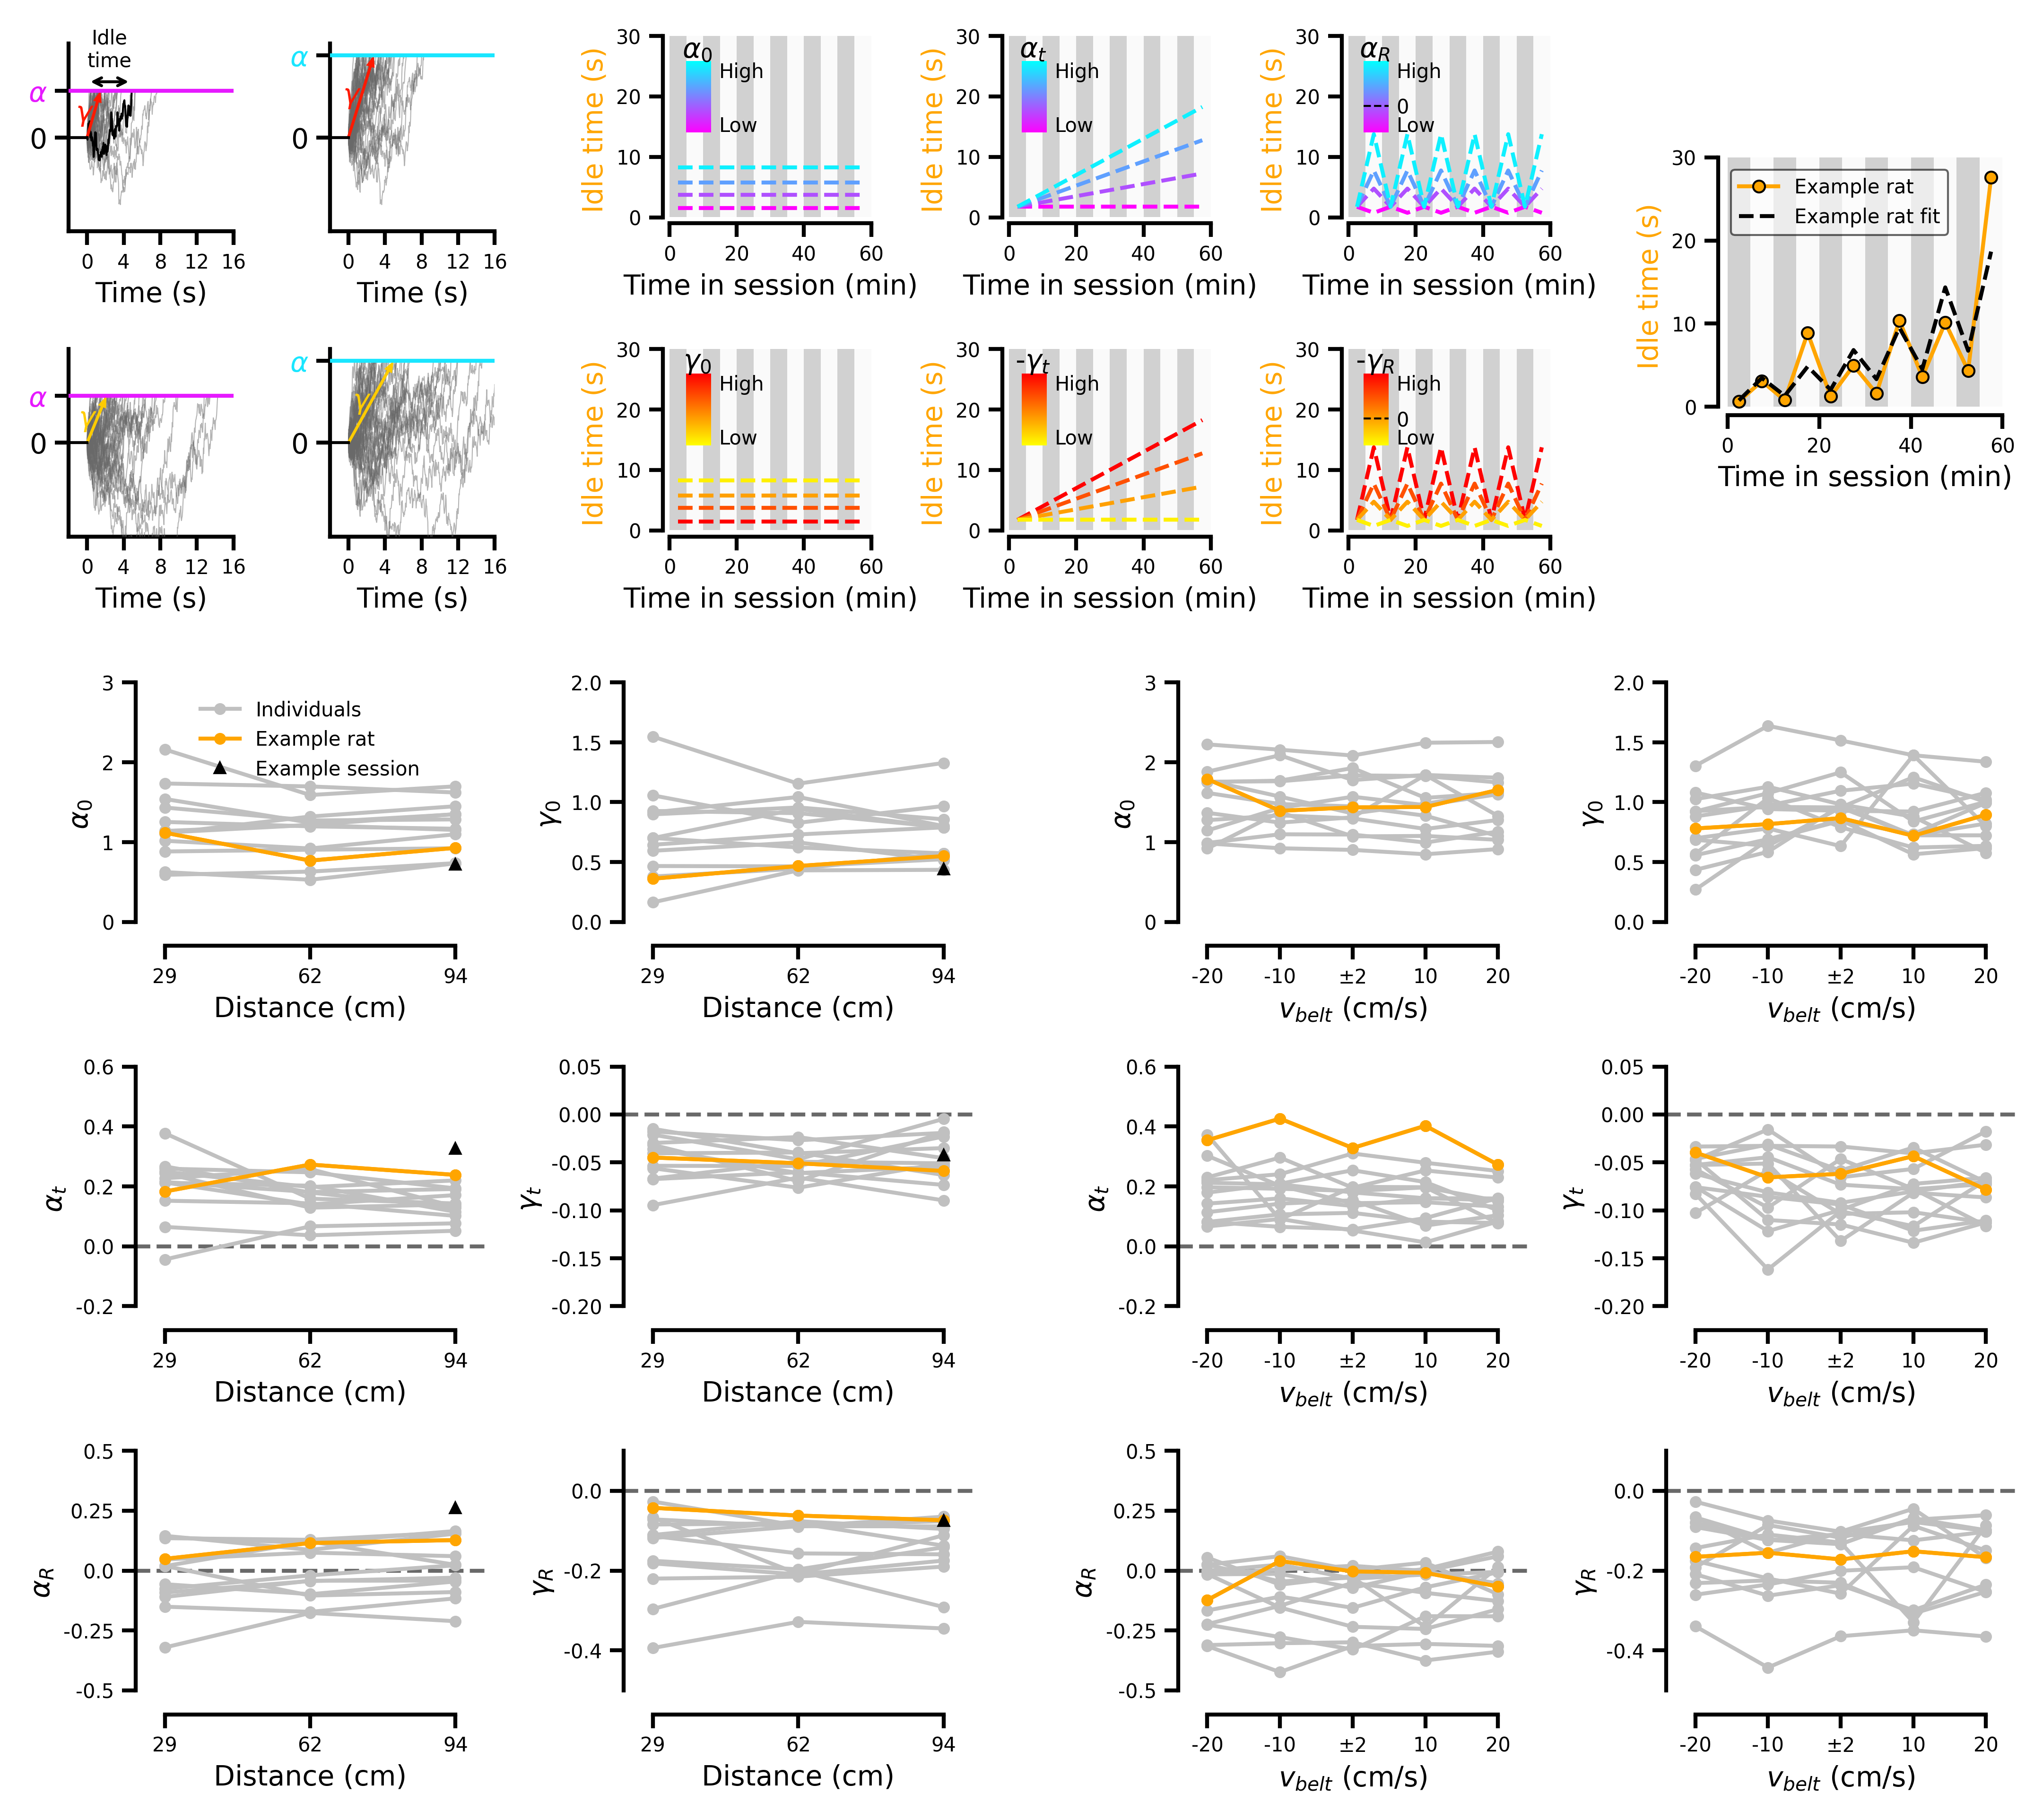

In [15]:

fig = plt.figure(figsize=(cm2inch(18), cm2inch(16)), 
                 constrained_layout=True, facecolor='w', dpi=600)

gs0 = fig.add_gridspec(3, 1, wspace=.5, hspace=.5, height_ratios=[1.6, .1, 3])

row1 = gs0[0].subgridspec(1, 5, width_ratios=[1, .1, 2, .1, .8])

drift_diffusion = row1[0, 0].subgridspec(2, 2, width_ratios=[1, 1], height_ratios=[1, 1])
drift_diffusion_base = plt.subplot(drift_diffusion[0, 0])
drift_diffusion_1 = plt.subplot(drift_diffusion[0, 1])
drift_diffusion_2 = plt.subplot(drift_diffusion[1, 0])
drift_diffusion_3 = plt.subplot(drift_diffusion[1, 1])


# blank = plt.subplot(row1[0, 1])
# # blank.axis("off")
# blank = plt.subplot(row1[0, 3])
# # blank.axis("off")
alpha_gamma = row1[0, 2].subgridspec(2, 3, width_ratios=[1, 1, 1], height_ratios=[1, 1])
explanation_alpha_0 = plt.subplot(alpha_gamma[0, 0])
explanation_alpha_t = plt.subplot(alpha_gamma[0, 1])
explanation_alpha_R = plt.subplot(alpha_gamma[0, 2])
explanation_gamma_0 = plt.subplot(alpha_gamma[1, 0])
explanation_gamma_t = plt.subplot(alpha_gamma[1, 1])
explanation_gamma_R = plt.subplot(alpha_gamma[1, 2])


modeldata_plot = row1[0, 4].subgridspec(3, 2, width_ratios=[1, 1], height_ratios=[1, 3, 1])
modeldata = plt.subplot(modeldata_plot[1 , :])




row2 = gs0[2].subgridspec(3, 5, width_ratios=[1, 1, .1, 1, 1])
fit_alpha_0_distance = plt.subplot(row2[0, 0])
fit_gamma_0_distance = plt.subplot(row2[0, 1])
fit_alpha_0_vbelt = plt.subplot(row2[0, 3])
fit_gamma_0_vbelt = plt.subplot(row2[0, 4])


fit_alpha_t_distance = plt.subplot(row2[1, 0])
fit_gamma_t_distance = plt.subplot(row2[1, 1])
fit_alpha_t_vbelt = plt.subplot(row2[1, 3])
fit_gamma_t_vbelt = plt.subplot(row2[1, 4])
fit_alpha_R_distance = plt.subplot(row2[2, 0])
fit_gamma_R_distance = plt.subplot(row2[2, 1])
fit_alpha_R_vbelt = plt.subplot(row2[2, 3])
fit_gamma_R_vbelt = plt.subplot(row2[2, 4])





Figure4_A(ax=drift_diffusion_base, A=8, mean=.2, base=True, alphacolor=plt.get_cmap('cool_r')(0.1), gammacolor=plt.get_cmap('autumn')(0.1))
Figure4_A(ax=drift_diffusion_1, A=14, mean=.2, base=False, alphacolor=plt.get_cmap('cool_r')(0.9), gammacolor=plt.get_cmap('autumn')(0.1))
Figure4_A(ax=drift_diffusion_2, A=8, mean=.1, base=False, alphacolor=plt.get_cmap('cool_r')(0.1), gammacolor=plt.get_cmap('autumn')(0.8))
Figure4_A(ax=drift_diffusion_3, A=14, mean=.1, base=False, alphacolor=plt.get_cmap('cool_r')(0.9), gammacolor=plt.get_cmap('autumn')(0.8))




Figure4A(ax=explanation_alpha_0, cmap=plt.get_cmap("cool_r"))
Figure4B(ax=explanation_alpha_t, cmap=plt.get_cmap("cool_r"))
Figure4C(ax=explanation_alpha_R, cmap=plt.get_cmap("cool_r"))
Figure4A(ax=explanation_gamma_0)
Figure4B(ax=explanation_gamma_t, reverse=True)
Figure4C(ax=explanation_gamma_R, reverse=True)
Figure4D(ax=modeldata)



Figure4F(ax=fit_alpha_0_distance)
Figure4G(ax=fit_alpha_t_distance)
Figure4H(ax=fit_alpha_R_distance)
Figure4I(ax=fit_gamma_0_distance)
Figure4J(ax=fit_gamma_t_distance)
Figure4K(ax=fit_gamma_R_distance)

Figure4L(ax=fit_alpha_0_vbelt)
Figure4M(ax=fit_alpha_t_vbelt)
Figure4N(ax=fit_alpha_R_vbelt)
Figure4O(ax=fit_gamma_0_vbelt)
Figure4P(ax=fit_gamma_t_vbelt)
Figure4Q(ax=fit_gamma_R_vbelt)

h, w = 0.04, 0.0125

cbarA = fig.add_axes([.333, .935, w, h])
plot_colorbar(ax=cbarA, label=r'$\alpha_0$', cmap="cool_r")

cbarB = fig.add_axes([.5, .935, w, h])
plot_colorbar(ax=cbarB, label=r'$\alpha_t$', cmap="cool_r")

cbarC = fig.add_axes([.67, .935, w, h])
plot_colorbar(ax=cbarC, label=r'$\alpha_R$', show_zero=150, cmap="cool_r")


cbarA = fig.add_axes([.333, .76, w, h])
plot_colorbar(ax=cbarA, label=r'$\gamma_0$', cmap="autumn_r")

cbarB = fig.add_axes([.5, .76, w, h])
plot_colorbar(ax=cbarB, label='-'+r'$\gamma_t$', cmap="autumn_r")

cbarC = fig.add_axes([.67, .76, w, h])
plot_colorbar(ax=cbarC, label='-'+r'$\gamma_R$', cmap="autumn_r", show_zero=150)


plt.savefig("/home/david/Desktop/code/Figure_4V2.pdf", facecolor='w', 
        edgecolor='none', bbox_inches='tight', format="pdf", dpi=600)

# old

[0.812139792180911, 1.6139910699615434, 1.1692466361479221, 1.9710979139285543, 1.5263534801149332, 2.328204757895566, 1.8834603240819443, 2.6853116018625762, 2.240567168048955, 3.0424184458295875, 2.597674012015966, 3.399525289796598]
[0.47336514094924226, 0.23649916083298797, 0.4262800826115629, 0.1894141024953086, 0.3791950242738835, 0.14232904415762918, 0.3321099659362041, 0.09524398581994983, 0.2850249075985248, 0.048158927482270464, 0.23793984926084544, 0.001073869144591108]


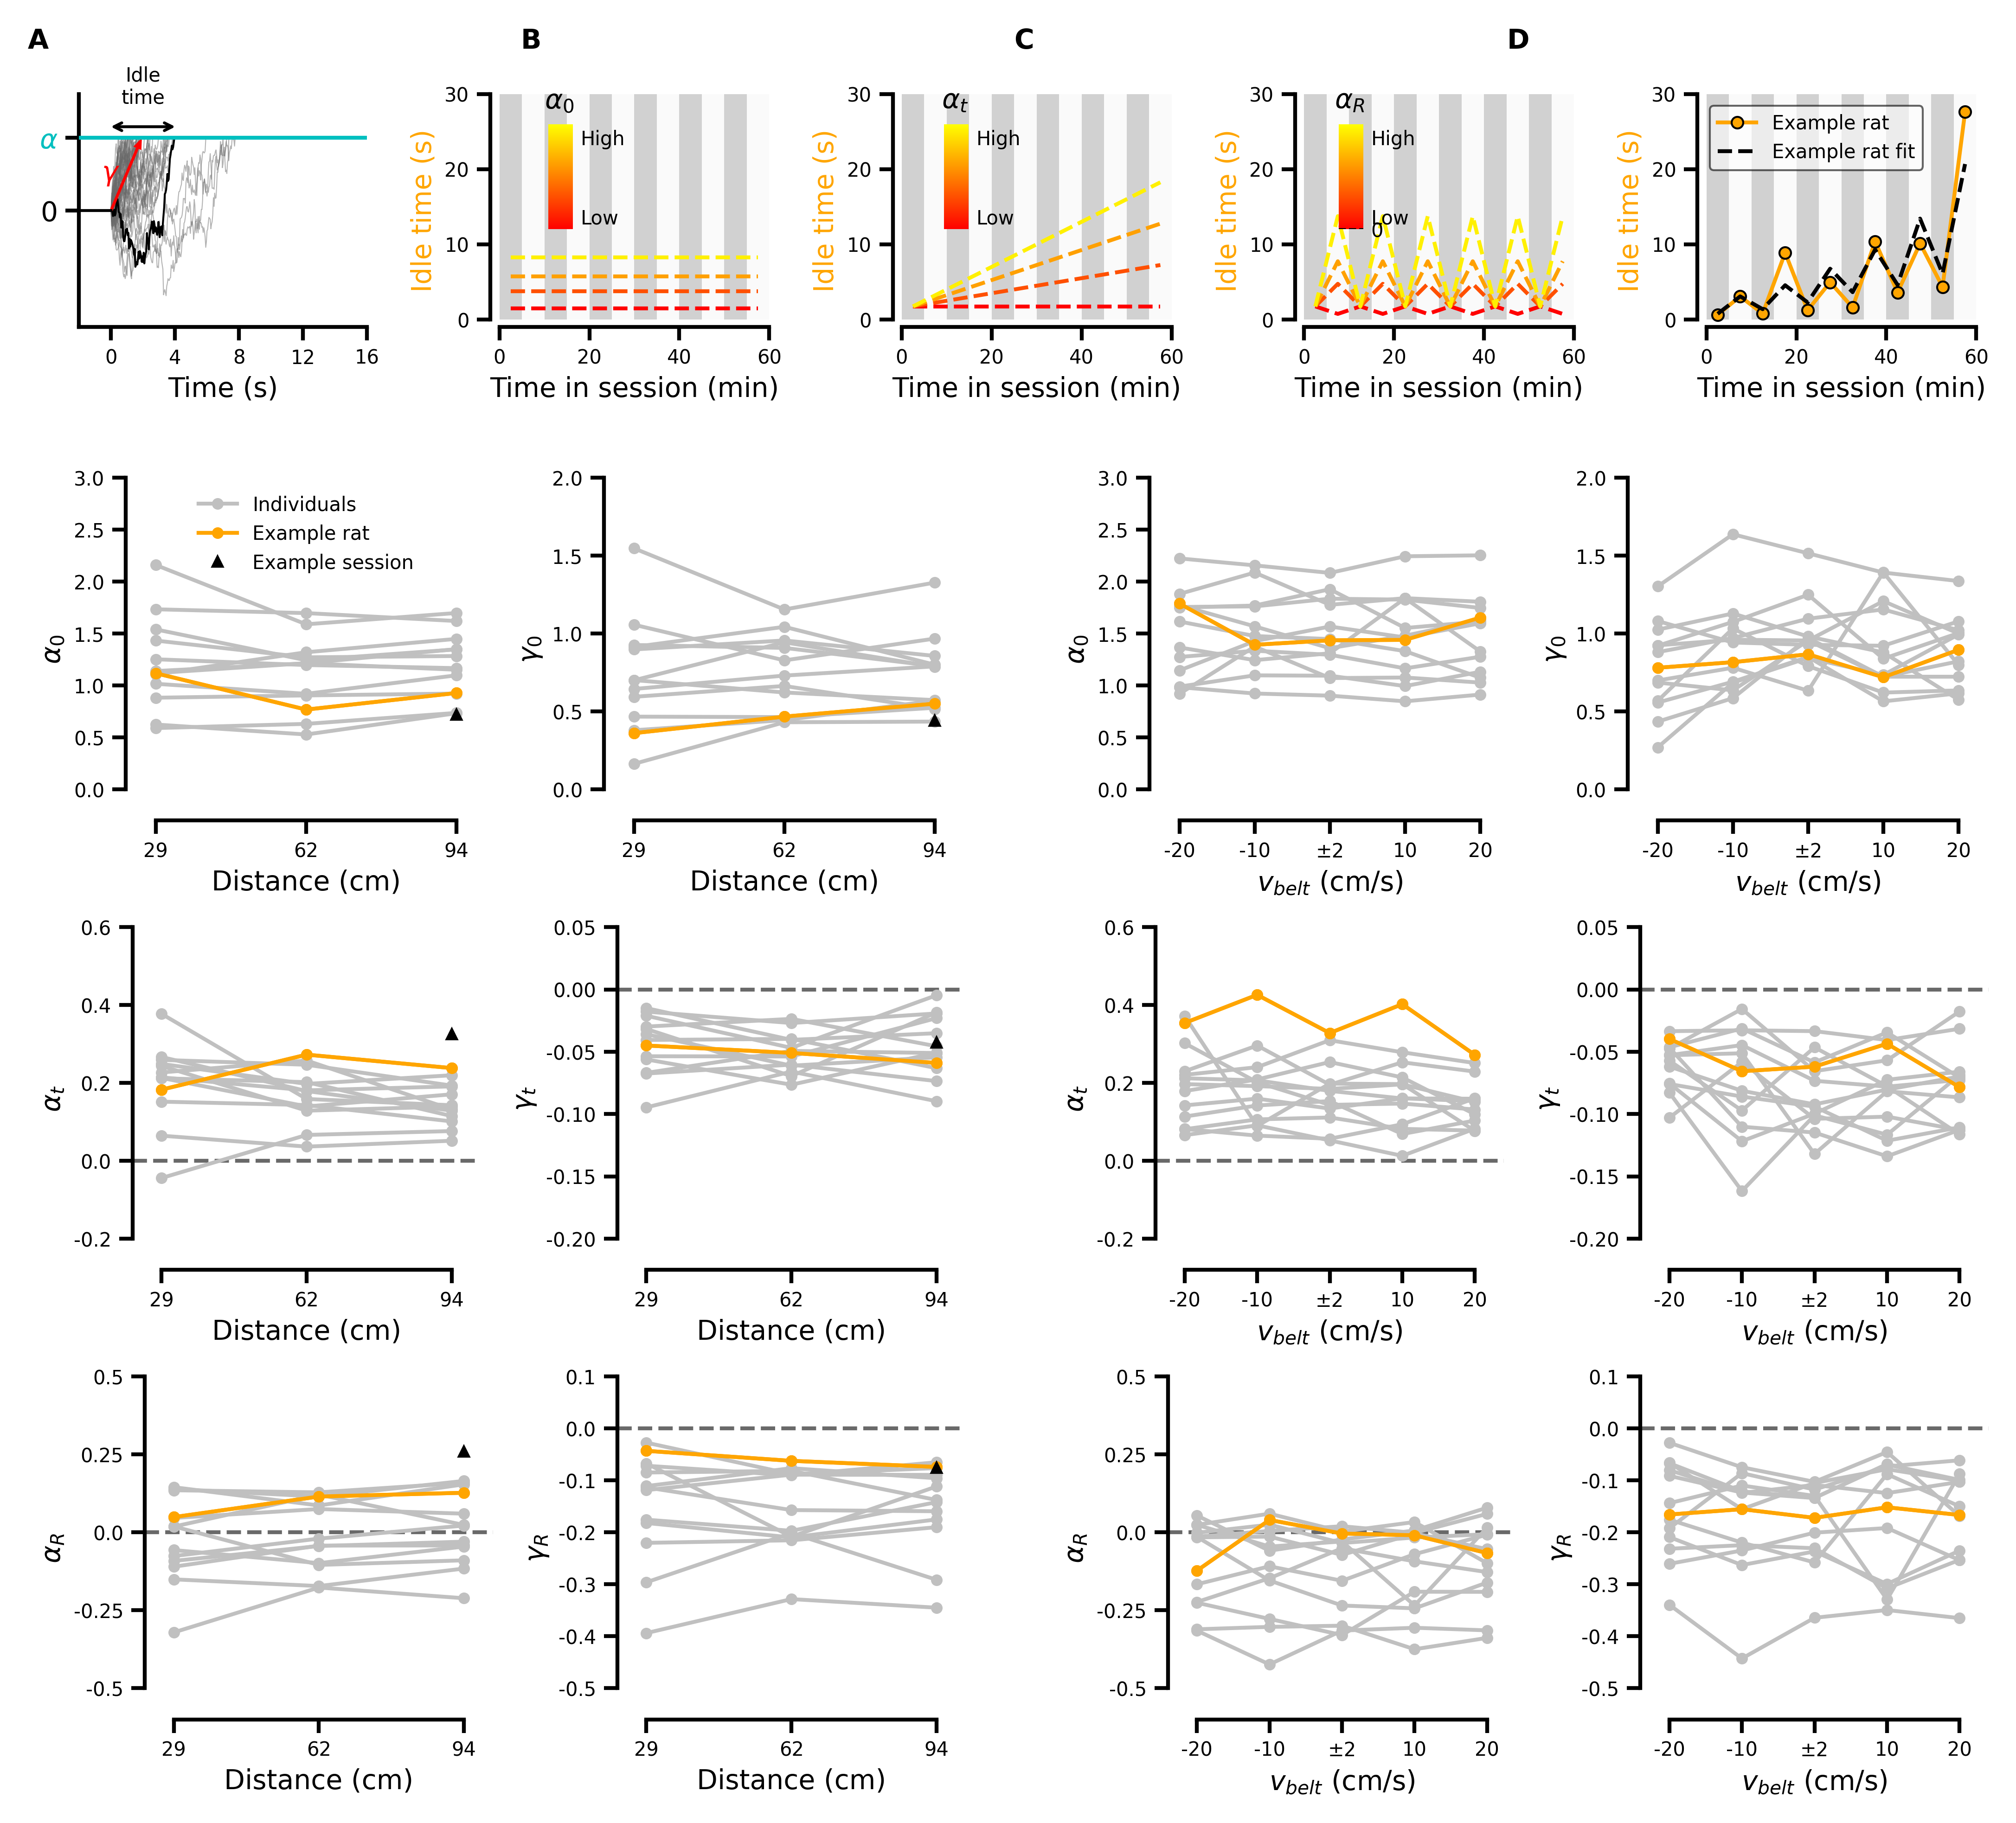

In [17]:

fig = plt.figure(figsize=(cm2inch(18), cm2inch(16)), 
                 constrained_layout=True, facecolor='w', dpi=600)

gs0 = fig.add_gridspec(5, 1, wspace=.5, hspace=.5, height_ratios=[.8, .1, 1, 1, 1])

row1 = gs0[0].subgridspec(1, 5)
drift_diffusion = plt.subplot(row1[0, 0])
explanation_alpha_0 = plt.subplot(row1[0, 1])
explanation_alpha_t = plt.subplot(row1[0, 2])
explanation_alpha_R = plt.subplot(row1[0, 3])
modeldata = plt.subplot(row1[0, 4])

row2 = gs0[2].subgridspec(1, 5, width_ratios=[1, 1, .1, 1, 1])
fit_alpha_0_distance = plt.subplot(row2[0, 0])
fit_gamma_0_distance = plt.subplot(row2[0, 1])
fit_alpha_0_vbelt = plt.subplot(row2[0, 3])
fit_gamma_0_vbelt = plt.subplot(row2[0, 4])


row3 = gs0[3].subgridspec(1, 5, width_ratios=[1, 1, .1, 1, 1])
fit_alpha_t_distance = plt.subplot(row3[0, 0])
fit_gamma_t_distance = plt.subplot(row3[0, 1])
fit_alpha_t_vbelt = plt.subplot(row3[0, 3])
fit_gamma_t_vbelt = plt.subplot(row3[0, 4])

row4 = gs0[4].subgridspec(1, 5, width_ratios=[1, 1, .1, 1, 1])
fit_alpha_R_distance = plt.subplot(row4[0, 0])
fit_gamma_R_distance = plt.subplot(row4[0, 1])
fit_alpha_R_vbelt = plt.subplot(row4[0, 3])
fit_gamma_R_vbelt = plt.subplot(row4[0, 4])



figuresLabels={"A":[0.00, 1.00], "B":[0.25, 1.00], "C":[0.50, 1.00], "D":[0.75, 1.00],
            #    "E":[0.00, 0.65], "F":[0.22, 0.65], "G":[0.415, 0.65], "H":[0.61, 0.65], "I":[0.805, 0.65],
            #    "J":[0.00, 0.31], "K":[0.22, 0.31], "L":[0.415, 0.31], "M":[0.61, 0.31], "N":[0.805, 0.31]
               }

for label,coordinates in sorted(figuresLabels.items()):
    fig.text(coordinates[0], coordinates[1],
             label, figure=fig, 
             weight='bold', fontsize=7, ha='left', va='bottom')

Figure4_A(ax=drift_diffusion)
Figure4A(ax=explanation_alpha_0)
Figure4B(ax=explanation_alpha_t)
Figure4C(ax=explanation_alpha_R)
Figure4D(ax=modeldata)



Figure4F(ax=fit_alpha_0_distance)
Figure4G(ax=fit_alpha_t_distance)
Figure4H(ax=fit_alpha_R_distance)
Figure4I(ax=fit_gamma_0_distance)
Figure4J(ax=fit_gamma_t_distance)
Figure4K(ax=fit_gamma_R_distance)

Figure4L(ax=fit_alpha_0_vbelt)
Figure4M(ax=fit_alpha_t_vbelt)
Figure4N(ax=fit_alpha_R_vbelt)
Figure4O(ax=fit_gamma_0_vbelt)
Figure4P(ax=fit_gamma_t_vbelt)
Figure4Q(ax=fit_gamma_R_vbelt)


h, w = 0.06, 0.0125

cbarA = fig.add_axes([.2638, .9, w, h])
plot_colorbar(ax=cbarA, label=r'$\alpha_0$')

cbarB = fig.add_axes([.4645, .9, w, h])
plot_colorbar(ax=cbarB, label=r'$\alpha_t$')

cbarC = fig.add_axes([.6646, .9, w, h])
plot_colorbar(ax=cbarC, label=r'$\alpha_R$', show_zero=True)

# plt.savefig("/home/david/Desktop/code/Figure_4.pdf", facecolor='w', 
#         edgecolor='none', bbox_inches='tight', format="pdf", dpi=600)